#Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from google.colab import auth
auth.authenticate_user()

from google.cloud import bigquery
client = bigquery.Client(project='djamo-data')
pd.set_option('display.max_columns', None)

#Extraction des données RFM 90 jour

In [11]:
# ===========================================
# Extraction des données RFM 90 jours - Djamo Fintech
# ===========================================

query = """
WITH snapshot_date_cte AS (
    SELECT DATE('2025-09-23') AS snapshot_date
),

eligible_clients AS (
    SELECT DISTINCT clientId AS clientid
    FROM `djamo-data.production_civ_djamo.public_account`
    WHERE DATE(createdAt) <= DATE_SUB((SELECT snapshot_date FROM snapshot_date_cte), INTERVAL 90 DAY)
),

active_clients_90d AS (
    SELECT DISTINCT clientid
    FROM `djamo-data.marts_growth.int_monthly_active_users`
    WHERE DATE(issueddate) BETWEEN DATE_SUB((SELECT snapshot_date FROM snapshot_date_cte), INTERVAL 90 DAY)
                               AND (SELECT snapshot_date FROM snapshot_date_cte)
      AND amount !=0

),

active_client AS (
    SELECT DISTINCT e.clientid
    FROM eligible_clients e
    INNER JOIN active_clients_90d a USING (clientid)
),

last_txn AS (
    SELECT
        m.clientid,
        DATE_DIFF((SELECT snapshot_date FROM snapshot_date_cte), MAX(DATE(m.issueddate)), DAY) AS days_since_last_transaction
    FROM `djamo-data.marts_growth.int_monthly_active_users` m
    WHERE DATE(m.issueddate) <= (SELECT snapshot_date FROM snapshot_date_cte)
      AND m.clientid IN (SELECT clientid FROM active_client)
    GROUP BY m.clientid
),

txn_90d AS (
    SELECT
        m.clientid,

        -- Compte toutes les transactions négatives ou >= 100 (0 exclu)
        COUNTIF(m.amount < 0 OR m.amount >= 100) AS txn_count_90d,

        -- Nombre de jours distincts avec au moins une transaction considérée
        COUNT(DISTINCT CASE WHEN m.amount < 0 OR m.amount >= 100 THEN DATE(m.issueddate) END) AS active_days_count_90d,

        -- Volume et stats calculés uniquement sur les débits avec montant <0 ou >=100
        SUM(CASE WHEN m.type = 'debit' AND (m.amount < 0 OR m.amount >= 100) THEN ABS(m.amount) ELSE 0 END) AS total_txn_volume_90d,
        AVG(CASE WHEN m.type = 'debit' AND (m.amount < 0 OR m.amount >= 100) THEN ABS(m.amount) END) AS avg_total_txn_volume_90d,
        STDDEV_POP(CASE WHEN m.type = 'debit' AND (m.amount < 0 OR m.amount >= 100) THEN ABS(m.amount) END) AS value_consistency_std

    FROM `djamo-data.marts_growth.int_monthly_active_users` m
    WHERE DATE(m.issueddate) BETWEEN DATE_SUB((SELECT snapshot_date FROM snapshot_date_cte), INTERVAL 90 DAY)
                               AND (SELECT snapshot_date FROM snapshot_date_cte)
      AND m.clientid IN (SELECT clientid FROM active_client)
    GROUP BY m.clientid
)
,

current_balance_snapshot AS (
    WITH ranked_balances AS (
        SELECT
            clientid,
            balance,
            updatedAt,
            ROW_NUMBER() OVER (PARTITION BY clientid ORDER BY updatedAt DESC) as rn
        FROM `djamo-data.production_civ_djamo.public_account`
        WHERE category = "primary"
          AND DATE(updatedAt) <= (SELECT snapshot_date FROM snapshot_date_cte)
          AND clientid IN (SELECT clientid FROM active_client)
    )
    SELECT clientid, balance AS current_account_balance_snapshot
    FROM ranked_balances
    WHERE rn = 1
),

vault_balance_snapshot AS (
    WITH ranked_vault_balances AS (
        SELECT
            clientid,
            balance,
            updatedAt,
            ROW_NUMBER() OVER (PARTITION BY clientid ORDER BY updatedAt DESC) as rn
        FROM `djamo-data.production_civ_djamo.public_account`
        WHERE category = "vault"
          AND DATE(updatedAt) <= (SELECT snapshot_date FROM snapshot_date_cte)
          AND clientid IN (SELECT clientid FROM active_client)
    )
    SELECT clientid, balance AS vault_balance_snapshot
    FROM ranked_vault_balances
    WHERE rn = 1
),

aum_snapshot AS (
    SELECT
        acc.clientId AS clientid,
        SUM(CAST(s.amount AS FLOAT64)) AS aum_snapshot
    FROM `djamo-data.production_civ_djamo.nsia_invest_account` acc
    JOIN `djamo-data.production_civ_djamo.nsia_invest_subscription` s
      ON acc.id = s.accountId
    WHERE acc.isActive = TRUE
      AND acc.deletedAt IS NULL
      AND s.status = 'validated'
      AND acc.clientId IN (SELECT clientid FROM active_client)
      AND DATE(s.updatedAt) <= (SELECT snapshot_date FROM snapshot_date_cte)
    GROUP BY acc.clientId
),

has_vault AS (
    SELECT DISTINCT clientid, 1 AS has_vault
    FROM `djamo-data.production_civ_djamo.public_account`
    WHERE category = "vault"
      AND clientid IN (SELECT clientid FROM active_client)
),

has_invest AS (
    SELECT DISTINCT clientId AS clientid, 1 AS has_invest
    FROM `djamo-data.production_civ_djamo.nsia_invest_account`
    WHERE isActive = TRUE
      AND deletedAt IS NULL
      AND clientId IN (SELECT clientid FROM active_client)
)

SELECT
    ac.clientid,
    (SELECT snapshot_date FROM snapshot_date_cte) AS snapshot_date,
    COALESCE(l.days_since_last_transaction, 90) AS days_since_last_transaction,  -- première feature
    COALESCE(t.txn_count_90d, 0) AS txn_count_90d,
    COALESCE(t.total_txn_volume_90d, 0) AS total_txn_volume_90d,
  -- COALESCE(t.active_days_count_90d, 0) AS active_days_count_90d,
  --  1 + COALESCE(vh.has_vault, 0) + COALESCE(ih.has_invest, 0) AS nb_active_products,
    COALESCE(t.value_consistency_std, 0) AS value_consistency_std,
   -- SAFE_DIVIDE(COALESCE(t.txn_count_90d, 0), GREATEST(COALESCE(t.active_days_count_90d, 0), 1)) AS txn_frequency_ratio,
   -- COALESCE(t.avg_total_txn_volume_90d, 0) AS avg_total_txn_volume_90d,
   -- COALESCE(cb.current_account_balance_snapshot, 0) AS current_account_balance,
   -- COALESCE(vb.vault_balance_snapshot, 0) AS vault_balance,
   -- COALESCE(a.aum_snapshot, 0) AS aum_snapshot,
   -- COALESCE(cb.current_account_balance_snapshot, 0) +
   -- COALESCE(vb.vault_balance_snapshot, 0) +
  -- COALESCE(a.aum_snapshot, 0) AS total_assets_snapshot,
   -- SAFE_DIVIDE(COALESCE(t.total_txn_volume_90d, 0), GREATEST(COALESCE(cb.current_account_balance_snapshot, 0), 1)) AS balance_velocity_90d
FROM active_client ac
LEFT JOIN txn_90d t ON ac.clientid = t.clientid
LEFT JOIN last_txn l ON ac.clientid = l.clientid
LEFT JOIN current_balance_snapshot cb ON ac.clientid = cb.clientid
LEFT JOIN vault_balance_snapshot vb ON ac.clientid = vb.clientid
LEFT JOIN aum_snapshot a ON ac.clientid = a.clientid
LEFT JOIN has_vault vh ON ac.clientid = vh.clientid
LEFT JOIN has_invest ih ON ac.clientid = ih.clientid
ORDER BY txn_count_90d DESC
"""

# Exécution de la requête
df_rfm_90d = client.query(query).to_dataframe()
print(df_rfm_90d.shape)
df_rfm_90d.head()


(264827, 6)


,clientid,snapshot_date,days_since_last_transaction,txn_count_90d,total_txn_volume_90d,value_consistency_std
0,87cede5e-ba5b-40a2-bd49-1e47e3c00022,2025-09-23,0,4842,25957541.32,17479.899551
1,f1f73e5d-6d0a-466f-8429-dc9fa364d8dd,2025-09-23,0,2912,6989086.20,5756.771127
2,a1cbaf89-f5cb-4ddd-a5c9-d82a339c69da,2025-09-23,0,2867,3478150.39,6216.198405
3,bd06675f-7345-469d-9ee1-78f9658e76fa,2025-09-23,0,2324,12136656.37,20446.846753
4,08f92075-7fd9-4465-b374-0391087d9708,2025-09-23,0,2097,7202091.02,10436.549416


In [12]:
value = df_rfm_90d.loc[df_rfm_90d['clientid'] == 'cbef9cab-0fcc-4142-8a47-a5061bc73ac5', 'total_txn_volume_90d'].values[0]
print(value)


168974.37


In [13]:
# Filtrer la ligne du client et sélectionner la colonne total_txn_volume_90d
df_rfm_90d.loc[df_rfm_90d['clientid'] == 'f51c2ed3-4dd1-4186-a968-ad9ebfbf4311', 'total_txn_volume_90d']


,total_txn_volume_90d
36351,241249.19


#Exploratory data analysis (EDA)

In [14]:

df_rfm_90d[['days_since_last_transaction', 'txn_count_90d', 'total_txn_volume_90d', 'value_consistency_std']].describe().round(2)



,days_since_last_transaction,txn_count_90d,total_txn_volume_90d,value_consistency_std
count,264827.0,264827.0,2.648270e+05,264827.00
mean,23.55,29.93,4.792159e+05,19729.58
std,25.18,63.38,1.926265e+06,50443.35
min,0.0,0.0,0.000000e+00,0.00
25%,3.0,4.0,3.994240e+03,56.49
50%,14.0,10.0,2.410023e+04,2128.59
75%,37.0,29.0,1.973861e+05,14393.26
max,90.0,4842.0,1.520321e+08,989197.32


In [15]:
percentiles = [0, 10, 25, 50, 75, 90, 95, 99, 100]
df_rfm_90d[['days_since_last_transaction', 'txn_count_90d', 'total_txn_volume_90d', 'value_consistency_std']].quantile([p/100 for p in percentiles]).round(2)


,days_since_last_transaction,txn_count_90d,total_txn_volume_90d,value_consistency_std
0.00,0.0,0.0,0.000000e+00,0.00
0.10,0.0,2.0,7.140000e+02,0.00
0.25,3.0,4.0,3.994240e+03,56.49
0.50,14.0,10.0,2.410023e+04,2128.59
0.75,37.0,29.0,1.973861e+05,14393.26
0.90,67.0,75.0,9.546960e+05,55588.28
0.95,78.0,124.0,2.205443e+06,102089.55
0.99,88.0,289.0,8.282801e+06,248948.15
1.00,90.0,4842.0,1.520321e+08,989197.32


#Segmentation

In [22]:
import pandas as pd

# --- Colonnes RFM ---
R = 'days_since_last_transaction'
F = 'txn_count_90d'
M = 'total_txn_volume_90d'

df_rfm = df_rfm_90d.copy()

# --- Attribution des scores R, F, M selon seuils business ---
def score_recency(x):
    if x <= 7: return 5
    elif x <= 14: return 4
    elif x <= 30: return 3
    elif x <= 60: return 2
    else: return 1

def score_frequency(x):
    if x >= 150: return 5
    elif x >= 50: return 4
    elif x >= 20: return 3
    elif x >= 5: return 2
    else: return 1

def score_monetary(x):
    if x >= 1_000_000: return 5
    elif x >= 100_000: return 4
    elif x >= 10_000: return 3
    elif x >= 1_000: return 2
    else: return 1

df_rfm['R_score'] = df_rfm[R].apply(score_recency)
df_rfm['F_score'] = df_rfm[F].apply(score_frequency)
df_rfm['M_score'] = df_rfm[M].apply(score_monetary)

# --- Score RFM numérique pour tri ---
df_rfm['RFM_score'] = df_rfm['R_score'].astype(str) + df_rfm['F_score'].astype(str) + df_rfm['M_score'].astype(str)
df_rfm['RFM_score_num'] = df_rfm[['R_score','F_score','M_score']].sum(axis=1)

# --- Attribution de segments marketing ---
def rfm_10_segments_business(row):
    R = row['R_score']
    F = row['F_score']
    M = row['M_score']

    if R == 5 and F == 5 and M == 5:
        return 'Champions'
    elif R >= 4 and F >= 4:
        return 'Fidèles Premium'
    elif R >= 4 and M >= 4:
        return 'Gros dépensiers occasionnels'
    elif R == 5 and F <= 2 and M <= 2:
        return 'Nouveaux Clients'
    elif R >= 3 and F >= 3 and M >= 3:
        return 'Réguliers Stables'
    elif R <= 2 and F <= 2 and M <= 2:
        return 'Clients Perdus / Inactifs'
    elif R <= 2 and M >= 4:
        return 'Anciens Gros Clients'
    elif R <= 3 and F >= 3 and M <= 3:
        return 'Irréguliers avec potentiel'
    elif R <= 3 and F <= 2 and M <= 3:
        return 'Hésitants / Peu actifs'
    else:
        return 'Nouveaux à activer'

df_rfm['Segment'] = df_rfm.apply(rfm_10_segments_business, axis=1)

# --- Résumé par segment sans RFM_score et sans RFM_score_num affichés ---
summary = df_rfm.groupby('Segment').agg(
    nb_clients=('clientid','count'),
    recency_min=(R,'min'),
    recency_mean=(R,'mean'),
    recency_max=(R,'max'),
    frequency_min=(F,'min'),
    frequency_mean=(F,'mean'),
    frequency_max=(F,'max'),
    monetary_min=(M,'min'),
    monetary_mean=(M,'mean'),
    monetary_max=(M,'max')
).reset_index()

# --- Pourcentage clients ---
summary['pct_clients'] = (summary['nb_clients'] / df_rfm.shape[0] * 100).round(2)

display(df_rfm[['clientid','R_score','F_score','M_score','RFM_score','RFM_score_num','Segment']].head(10))

# --- Trier par RFM_score_num sans l’afficher ---
summary = summary.merge(
    df_rfm.groupby('Segment')['RFM_score_num'].mean().reset_index(),
    on='Segment'
).sort_values('RFM_score_num', ascending=False).drop(columns='RFM_score_num')

# --- Affichage final ---
display(summary)
summary.to_csv('verification.csv')


,clientid,R_score,F_score,M_score,RFM_score,RFM_score_num,Segment
0,87cede5e-ba5b-40a2-bd49-1e47e3c00022,5,5,5,555,15,Champions
1,f1f73e5d-6d0a-466f-8429-dc9fa364d8dd,5,5,5,555,15,Champions
2,a1cbaf89-f5cb-4ddd-a5c9-d82a339c69da,5,5,5,555,15,Champions
3,bd06675f-7345-469d-9ee1-78f9658e76fa,5,5,5,555,15,Champions
4,08f92075-7fd9-4465-b374-0391087d9708,5,5,5,555,15,Champions
5,0312101f-e7f9-4b9b-a650-3866351ba8c3,5,5,5,555,15,Champions
6,e4e3e5b9-1b76-4b05-8a92-9b548dba3626,5,5,5,555,15,Champions
7,25326fca-ccd9-4bb4-b0c4-f5ba181202ae,5,5,5,555,15,Champions
8,7412d125-addb-4469-9623-13ee84824d99,5,5,5,555,15,Champions
9,0686c16a-6f72-4a95-9d62-b7288af2ac4a,5,5,5,555,15,Champions


,Segment,nb_clients,recency_min,recency_mean,recency_max,frequency_min,frequency_mean,frequency_max,monetary_min,monetary_mean,monetary_max,pct_clients
1,Champions,6906,0,0.835505,7,150,292.520851,4842,1000782.14,6.281206e+06,1.520321e+08,2.61
3,Fidèles Premium,30885,0,2.781836,14,50,95.697944,1489,0.00,1.492987e+06,6.706858e+07,11.66
4,Gros dépensiers occasionnels,31637,0,4.918766,14,1,25.924329,49,100000.00,6.856090e+05,3.159179e+07,11.95
9,Réguliers Stables,24000,0,11.402792,30,20,36.244708,1010,10000.00,2.730679e+05,4.050211e+07,9.06
8,Nouveaux à activer,42836,0,9.352881,30,0,9.47257,49,0.00,8.284355e+04,9.000000e+06,16.18
7,Nouveaux Clients,16268,0,3.219449,7,0,5.325793,19,0.00,3.537928e+03,9.999020e+03,6.14
0,Anciens Gros Clients,8246,31,51.741087,90,1,20.828887,1033,100000.00,5.214043e+05,2.443169e+07,3.11
6,Irréguliers avec potentiel,3021,15,44.155909,89,20,30.1857,162,0.00,3.876843e+04,9.993151e+04,1.14
5,Hésitants / Peu actifs,50713,15,33.422416,90,0,6.792085,19,0.00,2.027139e+04,9.998900e+04,19.15
2,Clients Perdus / Inactifs,50315,31,59.786267,90,0,3.173885,19,0.00,2.489803e+03,9.999990e+03,19.00


#Visualisation

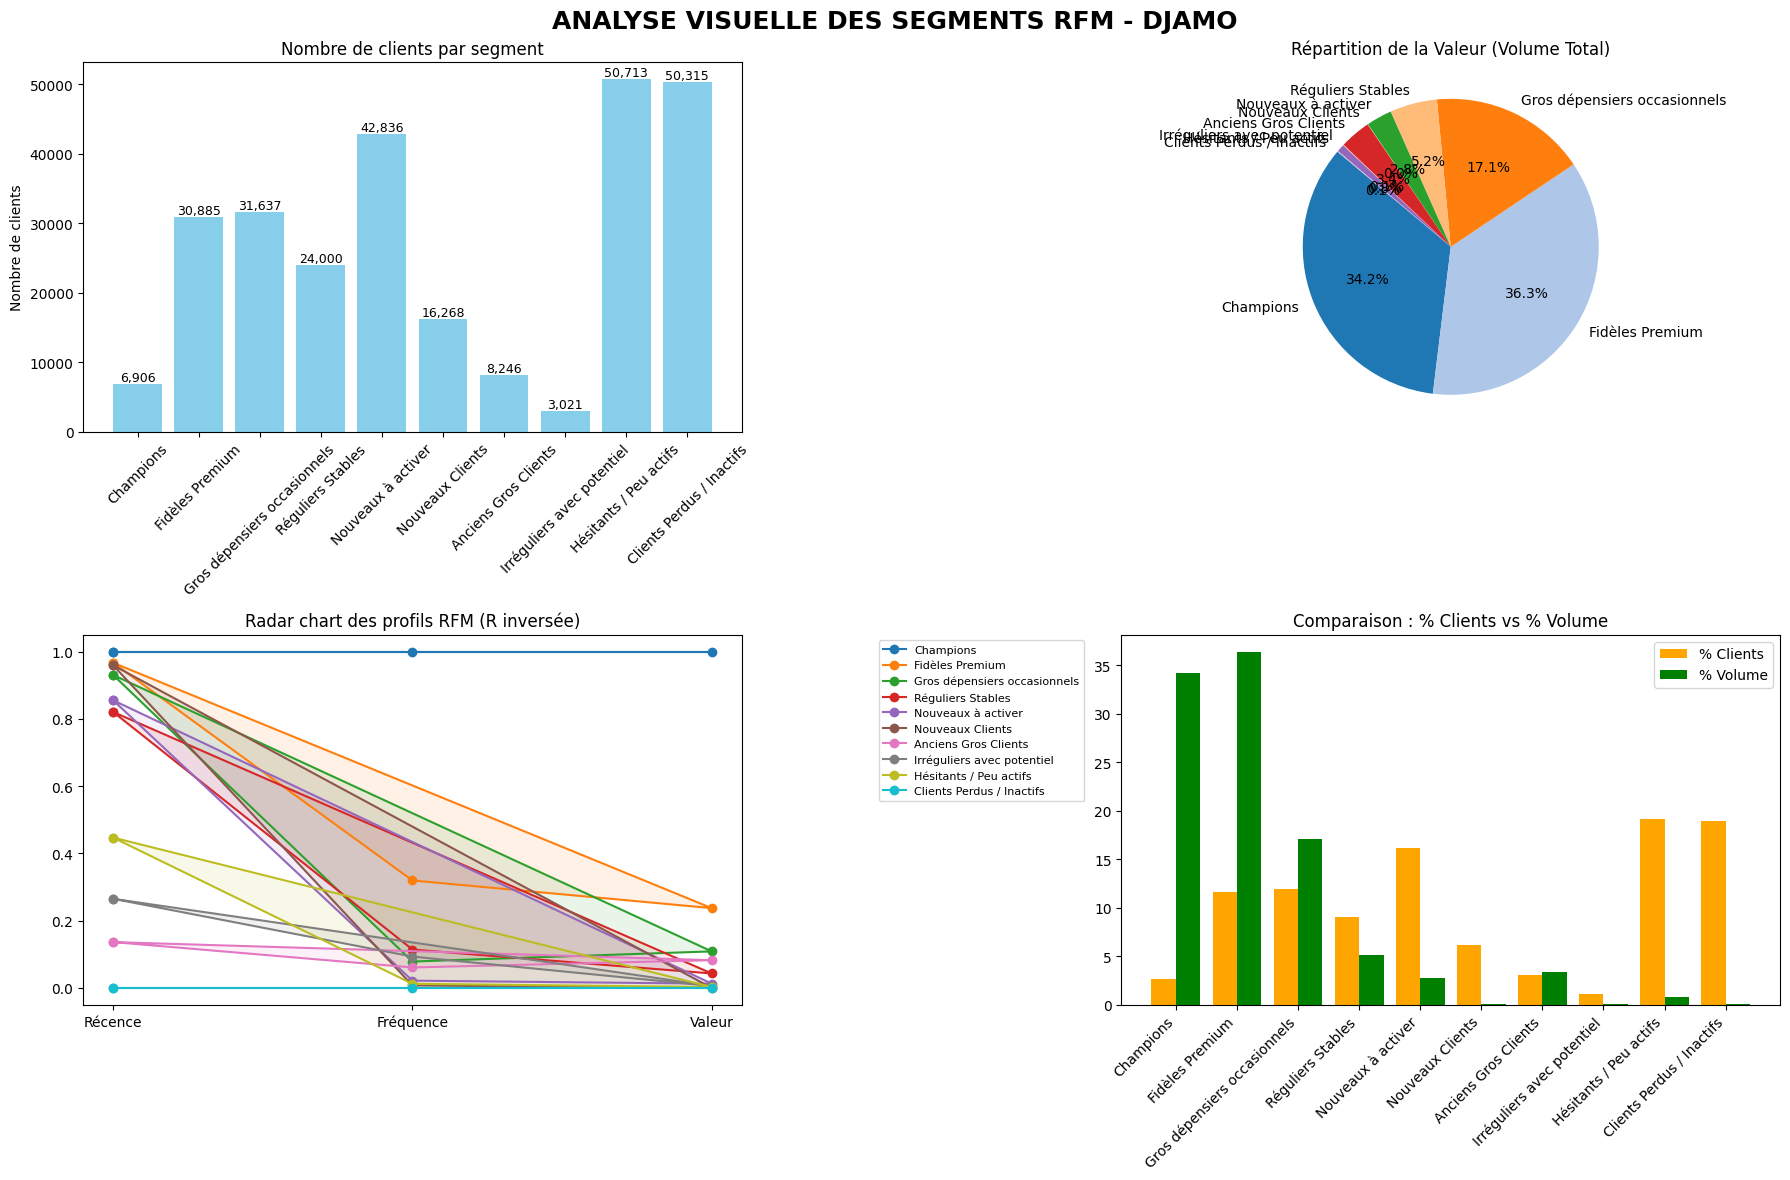

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# --- Copier le résumé final des segments ---
segment_stats = summary.copy()

# --- Pourcentage clients si pas encore calculé ---
if 'pct_clients' not in segment_stats.columns:
    segment_stats['pct_clients'] = 100 * segment_stats['nb_clients'] / segment_stats['nb_clients'].sum()

segment_stats['pct_client'] = segment_stats['pct_clients']

# --- Volume total par segment ---
segment_stats['total_volume'] = segment_stats['monetary_mean'] * segment_stats['nb_clients']
segment_stats['total_volume_abs'] = segment_stats['total_volume'].abs()
segment_stats['pct_volume'] = 100 * segment_stats['total_volume_abs'] / segment_stats['total_volume_abs'].sum()


# --- Création des subplots ---
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('ANALYSE VISUELLE DES SEGMENTS RFM - DJAMO', fontsize=18, fontweight='bold')


# --- 1️ Bar chart : nombre de clients ---
bars = axes[0, 0].bar(segment_stats['Segment'], segment_stats['nb_clients'], color='skyblue')
axes[0, 0].set_title("Nombre de clients par segment")
axes[0, 0].set_ylabel("Nombre de clients")
axes[0, 0].tick_params(axis="x", rotation=45)
for bar in bars:
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, height, f'{int(height):,}',
                    ha='center', va='bottom', fontsize=9)

# --- 2️ Pie chart : répartition valeur totale ---
axes[0, 1].pie(segment_stats['pct_volume'],
               labels=segment_stats['Segment'],
               autopct='%1.1f%%',
               startangle=140,
               colors=plt.cm.tab20.colors)
axes[0, 1].set_title('Répartition de la Valeur (Volume Total)')

# --- 3️ Radar chart : RFM normalisé avec recency inversée ---
rfm_cols = ['recency_mean','frequency_mean','monetary_mean']
rfm_agg = segment_stats[rfm_cols].fillna(0)

# Inversion de la récence : plus c'est récent, plus le score est élevé
rfm_agg['recency_mean'] = rfm_agg['recency_mean'].max() - rfm_agg['recency_mean']

# Normalisation MinMax pour visualisation
rfm_norm = rfm_agg.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

angles = np.linspace(0, 2*np.pi, len(rfm_cols), endpoint=False).tolist()
angles += angles[:1]

for idx, seg in enumerate(segment_stats['Segment']):
    vals = rfm_norm.iloc[idx].tolist()
    vals += vals[:1]
    axes[1, 0].plot(angles, vals, 'o-', label=seg)
    axes[1, 0].fill(angles, vals, alpha=0.1)

axes[1, 0].set_xticks(angles[:-1])
axes[1, 0].set_xticklabels(['Récence','Fréquence','Valeur'])
axes[1, 0].set_title("Radar chart des profils RFM (R inversée)")
axes[1, 0].legend(bbox_to_anchor=(1.2, 1), fontsize=8)

# --- 4️ Comparaison % Clients vs % Volume ---
x = np.arange(len(segment_stats))
axes[1, 1].bar(x - 0.2, segment_stats['pct_client'], width=0.4, label='% Clients', color='orange')
axes[1, 1].bar(x + 0.2, segment_stats['pct_volume'], width=0.4, label='% Volume', color='green')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(segment_stats['Segment'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].set_title("Comparaison : % Clients vs % Volume")

plt.tight_layout()
plt.show()


#interpretation

In [30]:
import pandas as pd

# --- 1️⃣ Définition des segments avec profils détaillés adaptés aux données réelles ---
segment_profiles_real = {
    'Champions': {
        'profil': 'Clients très récents, très actifs et gros dépensiers',
        'recency': 'très faible (moyenne 0.84 jours, min:0, max:7)',
        'fréquence': 'très élevée (moyenne 293, min:150, max:4842)',
        'valeur': 'très élevée (moyenne 6,281,206 FCFA)',
        'potentiel': 'Fidélisation VIP',
        'nb_clients': 6906
    },
    'Fidèles Premium': {
        'profil': 'Clients fidèles et actifs régulièrement',
        'recency': 'faible (moyenne 2.78 jours, min:0, max:14)',
        'fréquence': 'élevée (moyenne 96, min:50, max:1489)',
        'valeur': 'élevée (moyenne 1,492,987 FCFA)',
        'potentiel': 'Upselling & fidélisation',
        'nb_clients': 30885
    },
    'Gros dépensiers occasionnels': {
        'profil': 'Clients irréguliers mais gros dépensiers',
        'recency': 'faible (moyenne 4.92 jours, min:0, max:14)',
        'fréquence': 'faible (moyenne 26, min:1, max:49)',
        'valeur': 'élevée (moyenne 685,609 FCFA)',
        'potentiel': 'Augmenter la fréquence',
        'nb_clients': 31637
    },
    'Réguliers Stables': {
        'profil': 'Clients réguliers avec dépense moyenne',
        'recency': 'moyenne (moyenne 11.40 jours, min:0, max:30)',
        'fréquence': 'moyenne (moyenne 36, min:20, max:1010)',
        'valeur': 'moyenne (moyenne 273,068 FCFA)',
        'potentiel': 'Fidélisation',
        'nb_clients': 24000
    },
    'Nouveaux à activer': {
        'profil': 'Clients récents mais très peu actifs',
        'recency': 'faible-moyenne (moyenne 9.35 jours, min:0, max:30)',
        'fréquence': 'très faible (moyenne 9, min:0, max:49)',
        'valeur': 'faible (moyenne 82,844 FCFA)',
        'potentiel': 'Activation & onboarding',
        'nb_clients': 42836
    },
    'Nouveaux Clients': {
        'profil': 'Clients très récents, peu actifs',
        'recency': 'faible (moyenne 3.22 jours, min:0, max:7)',
        'fréquence': 'faible (moyenne 5, min:0, max:19)',
        'valeur': 'très faible (moyenne 3,538 FCFA)',
        'potentiel': 'Onboarding & engagement',
        'nb_clients': 16268
    },
    'Anciens Gros Clients': {
        'profil': 'Clients historiques à forte valeur mais en perte de récence',
        'recency': 'élevée (moyenne 51.74 jours, min:31, max:90)',
        'fréquence': 'moyenne (moyenne 21, min:1, max:1033)',
        'valeur': 'élevée (moyenne 521,404 FCFA)',
        'potentiel': 'Réactivation VIP',
        'nb_clients': 8246
    },
    'Irréguliers avec potentiel': {
        'profil': 'Clients irréguliers mais à exploiter',
        'recency': 'élevée (moyenne 44.16 jours, min:15, max:89)',
        'fréquence': 'moyenne (moyenne 30, min:20, max:162)',
        'valeur': 'moyenne (moyenne 38,768 FCFA)',
        'potentiel': 'Upsell & rétention',
        'nb_clients': 3021
    },
    'Hésitants / Peu actifs': {
        'profil': 'Clients peu actifs avec faible volume',
        'recency': 'élevée (moyenne 33.42 jours, min:15, max:90)',
        'fréquence': 'faible (moyenne 7, min:0, max:19)',
        'valeur': 'faible (moyenne 20,271 FCFA)',
        'potentiel': 'Réactivation ciblée',
        'nb_clients': 50713
    },
    'Clients Perdus / Inactifs': {
        'profil': 'Clients inactifs depuis longtemps',
        'recency': 'très élevée (moyenne 59.79 jours, min:31, max:90)',
        'fréquence': 'très faible (moyenne 3, min:0, max:19)',
        'valeur': 'très faible (moyenne 2,490 FCFA)',
        'potentiel': 'Réactivation difficile',
        'nb_clients': 50315
    }
}

# --- 2️ Création du DataFrame ---
segment_df_real = pd.DataFrame.from_dict(segment_profiles_real, orient='index')

# --- 3️ Calcul du pourcentage de clients par segment ---
total_clients_real = segment_df_real['nb_clients'].sum()
segment_df_real['pct_clients'] = (segment_df_real['nb_clients'] / total_clients_real * 100).round(2).astype(str) + "%"

# --- 4️ Export CSV ---
segment_df_real[['profil', 'recency', 'fréquence', 'valeur', 'potentiel', 'nb_clients', 'pct_clients']].to_csv('segment_df_real.csv', index_label='Segment')

# --- 5️ Affichage ---
segment_df_real[['profil', 'recency', 'fréquence', 'valeur', 'potentiel', 'nb_clients', 'pct_clients']]


,profil,recency,fréquence,valeur,potentiel,nb_clients,pct_clients
Champions,"Clients très récents, très actifs et gros dépe...","très faible (moyenne 0.84 jours, min:0, max:7)","très élevée (moyenne 293, min:150, max:4842)","très élevée (moyenne 6,281,206 FCFA)",Fidélisation VIP,6906,2.61%
Fidèles Premium,Clients fidèles et actifs régulièrement,"faible (moyenne 2.78 jours, min:0, max:14)","élevée (moyenne 96, min:50, max:1489)","élevée (moyenne 1,492,987 FCFA)",Upselling & fidélisation,30885,11.66%
Gros dépensiers occasionnels,Clients irréguliers mais gros dépensiers,"faible (moyenne 4.92 jours, min:0, max:14)","faible (moyenne 26, min:1, max:49)","élevée (moyenne 685,609 FCFA)",Augmenter la fréquence,31637,11.95%
Réguliers Stables,Clients réguliers avec dépense moyenne,"moyenne (moyenne 11.40 jours, min:0, max:30)","moyenne (moyenne 36, min:20, max:1010)","moyenne (moyenne 273,068 FCFA)",Fidélisation,24000,9.06%
Nouveaux à activer,Clients récents mais très peu actifs,"faible-moyenne (moyenne 9.35 jours, min:0, max...","très faible (moyenne 9, min:0, max:49)","faible (moyenne 82,844 FCFA)",Activation & onboarding,42836,16.18%
Nouveaux Clients,"Clients très récents, peu actifs","faible (moyenne 3.22 jours, min:0, max:7)","faible (moyenne 5, min:0, max:19)","très faible (moyenne 3,538 FCFA)",Onboarding & engagement,16268,6.14%
Anciens Gros Clients,Clients historiques à forte valeur mais en per...,"élevée (moyenne 51.74 jours, min:31, max:90)","moyenne (moyenne 21, min:1, max:1033)","élevée (moyenne 521,404 FCFA)",Réactivation VIP,8246,3.11%
Irréguliers avec potentiel,Clients irréguliers mais à exploiter,"élevée (moyenne 44.16 jours, min:15, max:89)","moyenne (moyenne 30, min:20, max:162)","moyenne (moyenne 38,768 FCFA)",Upsell & rétention,3021,1.14%
Hésitants / Peu actifs,Clients peu actifs avec faible volume,"élevée (moyenne 33.42 jours, min:15, max:90)","faible (moyenne 7, min:0, max:19)","faible (moyenne 20,271 FCFA)",Réactivation ciblée,50713,19.15%
Clients Perdus / Inactifs,Clients inactifs depuis longtemps,"très élevée (moyenne 59.79 jours, min:31, max:90)","très faible (moyenne 3, min:0, max:19)","très faible (moyenne 2,490 FCFA)",Réactivation difficile,50315,19.0%
